# Assignment 3: Unsupervised Learning and Probabilistic Models
Completed by Katarina Chiam (1004908996)

In [1]:
#google drive mount to colab statement
import os
from google.colab import drive

drive.mount('/content/drive')
root = '/content/drive/My Drive/_Y3/ECE421_W/A3'
os.chdir(root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


helper.py file

In [2]:
#import tensorflow as tf
%tensorflow_version 1.x as tf
import tensorflow as tf

def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x as tf`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


starter_kmeans.py file

Part 1: K-means

In [3]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

def load_data(is_valid = True, Dnum = 2): #Dnum depends on either using data2D or data100D
  # Loading data
  if Dnum == 2:
    file_name = 'data2D.npy'
  else: #Dnum == 100:
    file_name = 'data100D.npy'
  data = np.load(file_name)
  #data = np.load('data2D.npy')
  #data = np.load('data100D.npy')
  [num_pts, dim] = np.shape(data)

  # For Validation set
  if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]
    return data, val_data
  else:
    return data

# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    # TODO
    X_e = tf.expand_dims(X, axis = 1)
    MU_e = tf.expand_dims(MU, axis = 0)
    X_MU = tf.subtract(X_e, MU_e) #X_e - MU_e
    pair_dist = tf.reduce_sum(tf.square(X_MU), axis = 2)
    return pair_dist


K-means model training algorithm

In [14]:
#define loss function
def tf_loss(X, MU):
  pair_dist = distanceFunc(X, MU)
  reduced = tf.reduce_min(pair_dist, axis = 1)
  err = tf.reduce_sum(reduced)
  return err

#define function to compute data belonging to some cluster
def best_cluster(X, MU, K):
  N = X.shape[0]
  pair_dist = tf.Session().run(distanceFunc(X, MU))
  cluster = np.argmin(pair_dist, axis = 1)
  B = [] #holds the cluster information
  per = [] #holds the percentage of training points belonging to each cluster
  for k in range(K):
    B.append(X[cluster == k])
    per.append(len(B[k])/N)
  return B, per

In [5]:
#insert training here
def Kmeans_setup(K, D):
  X = tf.placeholder(tf.float64, shape = (None, D)) #X is NxD, variable for input data
  
  MU = tf.Variable(tf.truncated_normal(shape=(K, D), mean = 0.0, stddev = 1.0, dtype = tf.float64, seed = 421)) #initialize means as a standard normal distribution, means is KxD matrix

  loss = tf_loss(X, MU)

  optimizer = tf.train.AdamOptimizer(learning_rate = 0.1, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-5).minimize(loss)
  return X, MU, loss, optimizer

In [16]:
def Kmeans_model(K, epochs = 50, is_valid = False, Dnum = 2): #K is the number of classes
  trainData = load_data(is_valid, Dnum)
  trainLoss = []
  N = trainData.shape[0]
  D = trainData.shape[1]
  X, MU, loss, optimizer = Kmeans_setup(K, D)

  with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for ep in range(epochs):
      if ep % 25 == 0:
        print("epoch", ep)
      tr_loss, _ = sess.run([loss, optimizer], feed_dict={X:trainData})
      trainLoss.append(tr_loss/N)
    MU_star = MU.eval()
  
  cluster_data, percentages = best_cluster(trainData, MU_star, K)
  tf_plot(trainLoss, MU_star, cluster_data, percentages, K)

epoch 0
epoch 25




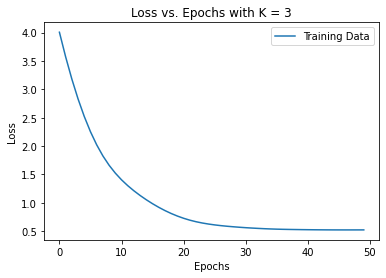

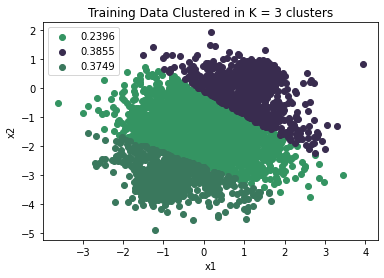

In [17]:
Kmeans_model(3)

In [7]:
def tf_plot(trainLoss, MU_star, cluster_data, percentages, K):
  plt.figure(1)
  plot1, = plt.plot(trainLoss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(r'Loss vs. Epochs with K = {}'.format(K))
  plt.legend([plot1], ['Training Data'])

  print("\n")
  plt.figure(2)
  plt.scatter(MU_star[:, 0], MU_star[:, -1])
  plt_names = [] #for the legend
  for k, value in enumerate(cluster_data):
    name = r'plot{}'.format(k)
    name = plt.scatter(value[:, 0], value[:, -1], color=np.random.rand(3,))
    plt_names.append(name)
  percent_string = map(str, percentages)
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.title("Training Data Clustered in K = {} clusters".format(K))
  plt.legend(plt_names, percent_string)

In [ ]:
#old stuff
#trainData = load_data(is_valid = False, Dnum = 2)
#print(trainData)
K = 3

MU_star, trainLoss = Kmeans_model(trainData, K)

cluster_data, percentages = best_cluster(trainData, MU_star, K) #returns list of points in cluster and another list of percentage of training points. index corresponds to the cluster

tf_plot(trainLoss, MU_star, cluster_data, percentages, K)

starter_gmm.py file

Part 2: Mixture of Gaussians

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

# Loading data
#data = np.load('data100D.npy')
data = np.load('data2D.npy')
[num_pts, dim] = np.shape(data)

# For Validation set
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

# Distance function for GMM
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)
    # TODO

def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    # TODO

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    # TODO